# Creación de librería para la selección de portafolios.

## Objetivos.

  ###### Objetivo General: 
 > Realizar una librería con varias funciones útiles para la selección de portafolios.

###### Objetivos Específicos:
> Investigar los comandos que contiene la librería CVXOPT.

> Proponer la nueva librería para la selección de portafolios.

> Resolver problemas de selección de portafolios una vez teniendo la librería.

> Comparar el trabajo realizado con las funciones minimize con CVXOPT.

## Descripción.

Primero, se tiene que investigar qué es la librería CVXOPT, como funciona y cuales son los componentes:

-  CVXOpt es un paquete gratuito que se utiliza para la optimización convexa. Su principal propósito, es conseguir el desarrollo de software para aplicaciones de optimización convexa mediante la construcción de una librería estándar extensa de Python y empleando las fortalezas de Python como lenguaje de programación de alto nivel.
- CVXOpt fue desarrollado inicialmente por Martin Andersen, Joachim Dahl y Lieven Vandenberghe para emplearlo en su propio trabajo (Bernarbé, 2013).

**¿Qué es la optimización convexa?  **

La optimización convexa trata el problema general de minimizar una función convexa, donde una función es convexa si su dominio $D$ ⊂ $R^n$ es convexo para todo $x, y$ ∈ $D$, para todo λ ∈ [0,1], se verifica:

$$f(λx + (1-λ)y) ≤ λf (x) + (1 − λ)f (y).$$

Donde por ejemplo: $ f(x) = x^2 $ es convexa. (Berrendero, s.f.)

Para instalar la librería, se utiliza el siguiente comando:

###### conda install -c conda-forge cvxopt

In [163]:
import cvxopt as opt
import cvxopt.solvers as optsolvers

In [164]:
help(opt)

Help on package cvxopt:

NAME
    cvxopt - Python package for convex optimization

DESCRIPTION
    CVXOPT is a free software package for convex optimization based on the 
    Python programming language. It can be used with the interactive Python 
    interpreter, on the command line by executing Python scripts, or 
    integrated in other software via Python extension modules. Its main 
    purpose is to make the development of software for convex optimization 
    applications straightforward by building on Python's extensive standard 
    library and on the strengths of Python as a high-level programming 
    language.

PACKAGE CONTENTS
    _version
    amd
    base
    blas
    cholmod
    coneprog
    cvxprog
    dsdp
    fftw
    glpk
    gsl
    info
    lapack
    misc
    misc_solvers
    modeling
    msk
    printing
    solvers
    umfpack

CLASSES
    builtins.object
        cvxopt.base.matrix
        cvxopt.base.spmatrix
    
    class matrix(builtins.object)
     |  Metho

In [165]:
help(optsolvers)

Help on module cvxopt.solvers in cvxopt:

NAME
    cvxopt.solvers - Convex optimization solvers.

DESCRIPTION
    conelp:   solves linear cone programs.
    coneqp:   solves quadratic cone programs.
    cp:       solves nonlinear convex problem.
    cpl:      solves nonlinear convex problems with linear objectives.
    gp:       solves geometric programs.
    lp:       solves linear programs.
    qp:       solves quadratic programs.
    sdp:      solves semidefinite programs.
    socp:     solves second-order cone programs.
    options:  dictionary with customizable algorithm parameters.

FUNCTIONS
    conelp(c, G, h, dims=None, A=None, b=None, primalstart=None, dualstart=None, kktsolver=None, xnewcopy=None, xdot=None, xaxpy=None, xscal=None, ynewcopy=None, ydot=None, yaxpy=None, yscal=None, **kwargs)
        Solves a pair of primal and dual cone programs
        
            minimize    c'*x
            subject to  G*x + s = h
                        A*x = b
                        s 

## Solución del problema: Creación de la librería.

In [656]:
def get_closes(tickers, start_date=None, end_date=None, freq=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Frecuencia de muestreo por defecto (freq='d')
    # Importamos paquetes necesarios
    import pandas as pd
    pd.core.common.is_list_like = pd.api.types.is_list_like
    import pandas_datareader.data as web  
    # Creamos DataFrame vacío de precios, con el índice de las fechas
    closes = pd.DataFrame(columns = tickers, index=web.YahooDailyReader(symbols=tickers[0], start=start_date, end=end_date, interval=freq).read().index)
    # Agregamos cada uno de los precios con YahooDailyReader
    for ticker in tickers:
        df = web.YahooDailyReader(symbols=ticker, start=start_date, end=end_date, interval=freq).read()
        closes[ticker]=df['Adj Close']
    closes.index_name = 'Date'
    closes = closes.sort_index()
    return closes

In [651]:
def Er(Eind,w):
    er = Eind.dot(w)
    return er

In [652]:
def var(w, Sigma):
    var = w.dot(Sigma).dot(w)
    return var

In [653]:
def sharpe(er,sp,rf):
    s = (er-rf)/sp
    return s

In [654]:
def max_sharpe(w,Sigma,rf,Eind):
    Erp = Eind.dot(w)
    varp = w.dot(Sigma).dot(w)
    return -(Erp-rf)/np.sqrt(varp)

In [655]:
def min_var(cov, allow_short=False):
    n = len(cov)
    cov_val = opt.matrix(cov.values)
    ceros = opt.matrix(0.0, (n, 1))

    if not allow_short:
        # x >= 0
        mat_idt = opt.matrix(-np.identity(n)) #matriz de identidad 
        ceros_mat_idt = opt.matrix(0.0, (n, 1))
    else:
        G = None
        h = None

    a = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    optsolvers.options['show_progress'] = False
    # qp(P, q, G=None, h=None, A=None, b=None, solver=None, kktsolver=None, initvals=None, **kwargs)
    # Se resuelve una función cuadrática
    sol = optsolvers.qp(cov_val, ceros, mat_idt, ceros_mat_idt, a, b)

    if sol['status'] != 'optimal':
        warnings.warn("Convergence problem")

    w = pd.Series(sol['x'], index=cov.index)
    return w

In [657]:
def optimal_portfolio(daily_ret, n_opt, risk_free):
    # Frontier points
    #Packages
    import pandas as pd
    import sklearn.covariance as skcov
    import numpy as np
    import cvxopt as opt
    from cvxopt import blas, solvers
    num_stocks = daily_ret.columns.size   
    #cvxopt matrices
    robust_cov_matrix = skcov.ShrunkCovariance().fit(daily_ret).covariance_
    S = opt.matrix(robust_cov_matrix)
    daily_ret_mean = daily_ret.mean().values
    mus = np.linspace(daily_ret_mean.min(), daily_ret_mean.max(), n_opt)
    # Constraint matrices
    G = -opt.matrix(np.concatenate((np.array([daily_ret_mean]),np.eye(num_stocks)),axis=0))
    p = opt.matrix(np.zeros((num_stocks, 1)))
    A = opt.matrix(np.ones((1,num_stocks)))
    b = opt.matrix(np.array([1.0]))    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = np.zeros((n_opt, num_stocks))
    for k in range(n_opt):
        h = -opt.matrix(np.concatenate((np.array([[mus[k]]]),np.zeros((num_stocks,1))), axis=0))
        portfolios[k,:] = np.asarray(solvers.qp(S, p, G, h, A, b)['x']).T[0]
    # Risk and returns
    returns = 252*portfolios.dot(daily_ret_mean)
    risks = np.zeros(n_opt)
    for i in range(n_opt):
        risks[i] = np.sqrt(252*portfolios[i,:].dot(robust_cov_matrix).dot(portfolios[i,:].T))
    sharpe = (returns-risk_free)/risks
    return  pd.DataFrame(data=np.column_stack((returns,risks,sharpe,portfolios)),
                         columns=(['Rendimiento','SD','Sharpe']+list(daily_ret.columns)))

## Resultados.

#### *Vamos a obtener los pesos del portafolio de mínima varianza de diferentes activos:*

In [760]:
# Importar datos
names1 = ['AAPL','MSFT','GCARSOA1.MX','BAC','TSLA','PCG','NFLX']
names2 = ['C','T','CSCO','FB','TWTR','MSFT','SNAP']
names = names1+names2
start_date = '2015-11-01'
end_date = '2018-11-07'
rf = 0.0312/12 #tasa libre de riesgo de EEUU a 10 años... /12 porque vamos a bajar datos mensuales.

In [747]:
# Precios mensuales
monthly_closes1 = get_closes(names1, start_date=start_date, end_date=end_date, freq='m')

In [761]:
monthly_closes2 = get_closes(names2, start_date=start_date, end_date=end_date, freq='m')

In [768]:
monthly_closes = get_closes(names, start_date=start_date, end_date=end_date, freq='m')

In [769]:
monthly_closes

,AAPL,MSFT,GCARSOA1.MX,BAC,TSLA,PCG,NFLX,C,T,CSCO,FB,TWTR,MSFT,SNAP
Date,,,,,,,,,,,,,,
2015-11-01,111.730812,50.740330,70.638725,16.635330,230.259995,49.510780,123.330002,51.680984,28.810776,24.675766,104.239998,25.400000,50.740330,NaN
2015-12-01,99.840477,52.144402,68.300453,16.062685,240.009995,49.942699,114.379997,49.445194,29.443977,24.594265,104.660004,23.139999,52.144402,NaN
2016-01-01,92.328247,51.777847,70.157600,13.533323,191.199997,51.995975,91.839996,40.683613,30.855854,21.542622,112.209999,16.799999,51.777847,NaN
2016-02-01,91.711731,47.820961,70.475136,11.982829,191.929993,53.719383,93.410004,37.165543,32.062340,23.891569,106.919998,18.120001,47.820961,NaN
2016-03-01,103.939392,52.282135,77.528427,12.939922,229.770004,56.550716,102.230003,39.939804,33.988674,25.981398,114.099998,16.549999,52.282135,NaN
2016-04-01,89.396065,47.208221,79.164253,13.988327,240.759995,55.543232,90.029999,44.273388,33.684975,25.087057,117.580002,14.620000,47.208221,NaN
2016-05-01,95.232468,50.171154,75.151665,14.209296,223.229996,57.337406,102.570000,44.597935,34.392563,26.753145,118.809998,15.220000,50.171154,NaN
2016-06-01,91.724960,48.777630,75.522438,12.748977,212.279999,61.002117,91.480003,40.594948,37.959202,26.421612,114.279999,16.910000,48.777630,NaN
2016-07-01,99.985970,54.030018,74.099861,13.968297,234.789993,61.498238,91.250000,41.954815,38.029484,28.116137,123.940002,16.639999,54.030018,NaN


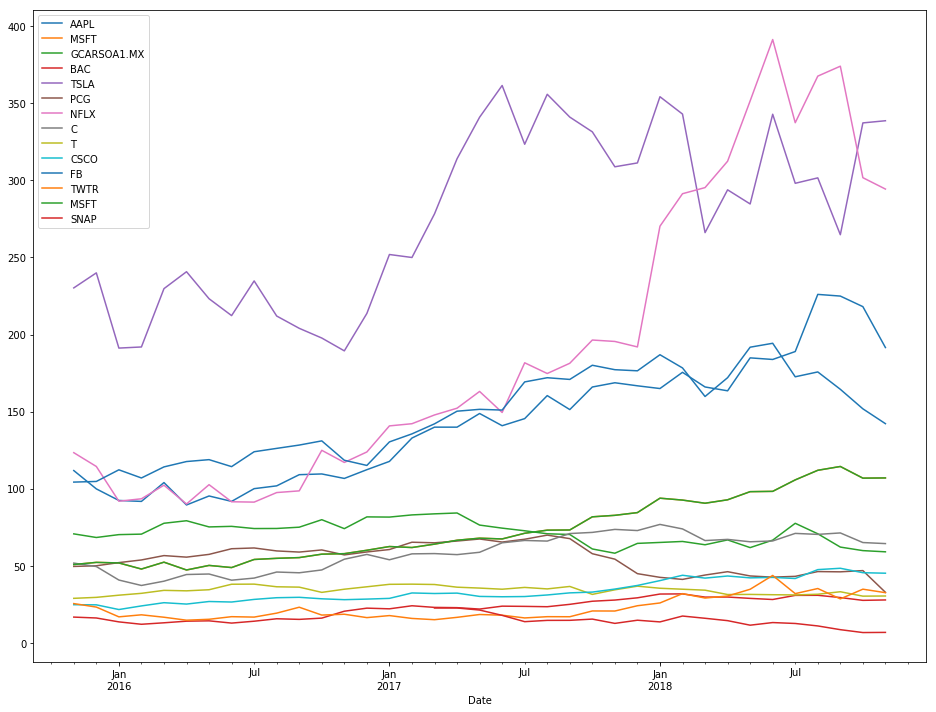

In [770]:
# Gráfico
monthly_closes.plot(figsize=(16,12));

In [771]:
# Rendimientos mensuales
monthly_ret = monthly_closes.pct_change().dropna()
monthly_ret

,AAPL,MSFT,GCARSOA1.MX,BAC,TSLA,PCG,NFLX,C,T,CSCO,FB,TWTR,MSFT,SNAP
Date,,,,,,,,,,,,,,
2017-04-01,-0.000070,0.039478,0.006631,-0.007582,0.128530,0.017804,0.029700,-0.011702,-0.046209,0.007988,0.057726,0.102341,0.039478,0.000888
2017-05-01,0.063418,0.020158,-0.093147,-0.039846,0.085777,0.019836,0.071419,0.026752,-0.016143,-0.066490,0.008053,0.111650,0.020158,-0.059424
2017-06-01,-0.053322,-0.007372,-0.025997,0.086108,0.060409,-0.029395,-0.083768,0.104724,-0.020763,-0.007295,-0.003169,-0.024563,-0.007372,-0.162188
2017-07-01,0.032704,0.054693,-0.022995,-0.005771,-0.105473,0.028016,0.215849,0.023475,0.033660,0.004792,0.121009,-0.099608,0.054693,-0.230726
2017-08-01,0.102669,0.028473,-0.026805,-0.009536,0.100257,0.039740,-0.038258,-0.006136,-0.026980,0.033734,0.016071,0.050963,0.028473,0.061448
2017-09-01,-0.056554,0.001563,-0.006505,0.066121,-0.041585,-0.032538,0.038006,0.074186,0.045649,0.044086,-0.006396,-0.002365,0.001563,0.002068
2017-10-01,0.096808,0.116660,-0.133742,0.080900,-0.028056,-0.144896,0.083154,0.010448,-0.140924,0.015462,0.053784,0.222288,0.116660,0.055021
2017-11-01,0.016623,0.011902,-0.045513,0.028478,-0.068410,-0.061104,-0.004684,0.027211,0.094706,0.059738,-0.015995,-0.001940,0.011902,-0.181226
2017-12-01,-0.011706,0.021380,0.109931,0.052389,0.008095,-0.173488,-0.018158,-0.010199,0.068719,0.067447,-0.004064,0.166667,0.021380,0.163217


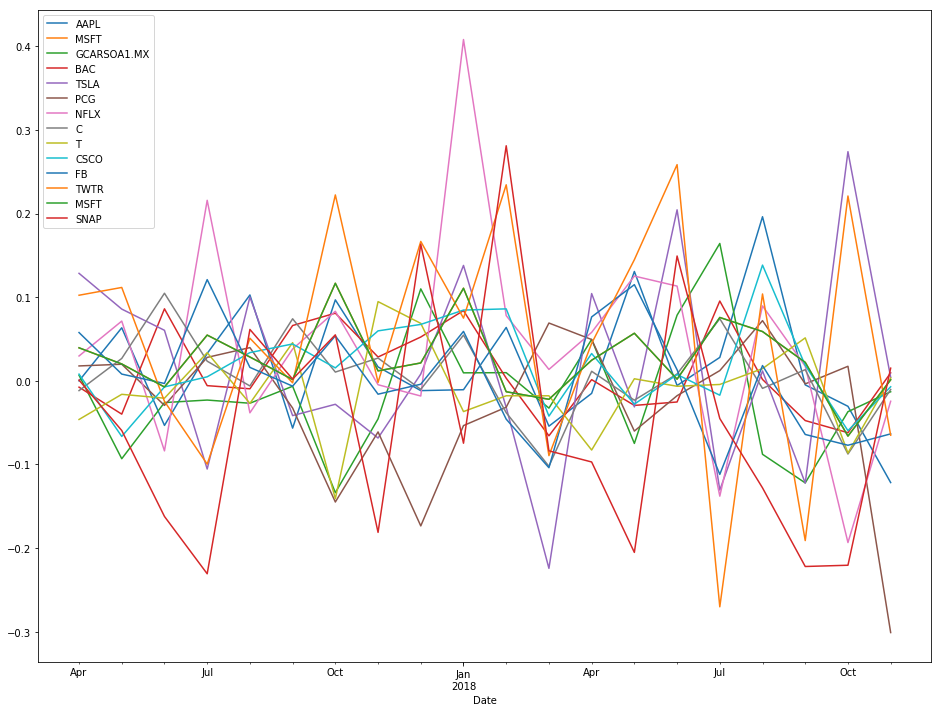

In [773]:
monthly_ret.plot(figsize=(16,12));

In [819]:
# Matriz de covarianza
cov = monthly_ret.cov()
cov

,AAPL,MSFT,GCARSOA1.MX,BAC,TSLA,PCG,NFLX,C,T,CSCO,FB,TWTR,MSFT,SNAP
AAPL,0.005487,0.001545,-0.001857,-0.000274,-0.000340,0.002328,0.002106,-0.000279,-0.000370,0.001269,0.001977,0.003294,0.001545,-0.000075
MSFT,0.001545,0.001916,-0.000188,0.001172,-0.000934,-0.000391,0.003224,0.000911,-0.000400,0.000728,0.001498,-0.000575,0.001916,-0.000094
GCARSOA1.MX,-0.001857,-0.000188,0.005527,0.001314,0.000955,-0.000319,-0.001454,0.000693,0.000571,0.000296,-0.000974,-0.001305,-0.000188,0.004406
BAC,-0.000274,0.001172,0.001314,0.002606,-0.000589,-0.001669,0.000683,0.001895,-0.000011,0.001008,0.000291,-0.001061,0.001172,0.001570
TSLA,-0.000340,-0.000934,0.000955,-0.000589,0.014820,0.000314,0.000017,-0.000194,-0.002907,-0.000255,0.001957,0.011141,-0.000934,0.002201
PCG,0.002328,-0.000391,-0.000319,-0.001669,0.000314,0.008108,0.000119,-0.000396,-0.000498,-0.000203,0.000333,-0.001493,-0.000391,-0.004077
NFLX,0.002106,0.003224,-0.001454,0.000683,0.000017,0.000119,0.016024,0.001020,0.000071,0.002543,0.005394,0.003318,0.003224,0.000530
C,-0.000279,0.000911,0.000693,0.001895,-0.000194,-0.000396,0.001020,0.002484,0.000585,0.000472,0.000703,-0.002534,0.000911,-0.000591
T,-0.000370,-0.000400,0.000571,-0.000011,-0.002907,-0.000498,0.000071,0.000585,0.003040,0.000801,-0.000530,-0.003070,-0.000400,-0.000854
CSCO,0.001269,0.000728,0.000296,0.001008,-0.000255,-0.000203,0.002543,0.000472,0.000801,0.002667,0.000670,0.001221,0.000728,0.002244


In [808]:
# Matriz de correlacion
corr = monthly_ret.corr()
corr

,AAPL,MSFT,GCARSOA1.MX,BAC,TSLA,PCG,NFLX,C,T,CSCO,FB,TWTR,MSFT,SNAP
AAPL,1.000000,0.476454,-0.337171,-0.072388,-0.037648,0.349072,0.224588,-0.075515,-0.090511,0.331837,0.401505,0.308074,0.476454,-0.007088
MSFT,0.476454,1.000000,-0.057906,0.524519,-0.175218,-0.099102,0.581968,0.417574,-0.165563,0.322281,0.514899,-0.090971,1.000000,-0.015140
GCARSOA1.MX,-0.337171,-0.057906,1.000000,0.346206,0.105481,-0.047637,-0.154487,0.186966,0.139292,0.077089,-0.196997,-0.121590,-0.057906,0.417418
BAC,-0.072388,0.524519,0.346206,1.000000,-0.094727,-0.363046,0.105675,0.744709,-0.003918,0.382158,0.085866,-0.144044,0.524519,0.216601
TSLA,-0.037648,-0.175218,0.105481,-0.094727,1.000000,0.028663,0.001112,-0.032052,-0.433150,-0.040513,0.241745,0.634091,-0.175218,0.127331
PCG,0.349072,-0.099102,-0.047637,-0.363046,0.028663,1.000000,0.010479,-0.088328,-0.100354,-0.043623,0.055613,-0.114903,-0.099102,-0.318862
NFLX,0.224588,0.581968,-0.154487,0.105675,0.001112,0.010479,1.000000,0.161647,0.010150,0.388958,0.640960,0.181585,0.581968,0.029486
C,-0.075515,0.417574,0.186966,0.744709,-0.032052,-0.088328,0.161647,1.000000,0.212885,0.183281,0.212186,-0.352268,0.417574,-0.083525
T,-0.090511,-0.165563,0.139292,-0.003918,-0.433150,-0.100354,0.010150,0.212885,1.000000,0.281188,-0.144581,-0.385759,-0.165563,-0.109070
CSCO,0.331837,0.322281,0.077089,0.382158,-0.040513,-0.043623,0.388958,0.183281,0.281188,1.000000,0.195106,0.163812,0.322281,0.305980


In [809]:
# Resumen diario
monthly_ret_summary = pd.DataFrame(index=['Mean', 'Volatility'], columns=names)
monthly_ret_summary.loc['Mean']=monthly_ret.mean()
monthly_ret_summary.loc['Volatility']=monthly_ret.std()
monthly_ret_summary

,AAPL,MSFT,GCARSOA1.MX,BAC,TSLA,PCG,NFLX,C,T,CSCO,FB,TWTR,MSFT,SNAP
Mean,0.0183474,0.0268952,-0.014696,0.0108155,0.0168097,-0.0291804,0.0420421,0.00651352,-0.00945661,0.0186499,0.00213864,0.0496056,0.0268952,-0.0490806
Volatility,0.0740754,0.043767,0.0743417,0.0510496,0.121738,0.0900432,0.126586,0.0498355,0.0551361,0.0516434,0.0664831,0.144329,0.043767,0.141998


In [810]:
w_MVP = min_var(cov)
round(w_MVP,6)

AAPL           0.000000
MSFT           0.138984
GCARSOA1.MX    0.005947
BAC            0.135216
TSLA           0.076682
PCG            0.128141
NFLX           0.000000
C              0.000001
T              0.313817
CSCO           0.000001
FB             0.000002
TWTR           0.039179
MSFT           0.138984
SNAP           0.023045
dtype: float64

In [811]:
Eind = monthly_ret.mean()

Er_MVP = Er(Eind,w_MVP)
Er_MVP

0.00424570090348821

In [812]:
Vol = monthly_ret.std()
D = np.diag(Vol)
Sigma = D.dot(cov).dot(D)

sp_MVP = np.sqrt(var(w_MVP,Sigma))
sp_MVP

0.0018011756758498105

In [813]:
sharpe_MVP = sharpe(Er_MVP,sp_MVP,rf)
sharpe_MVP

0.9136815056708748

Portafolio EMV:

In [814]:
from scipy.optimize import minimize
# Dato inicial
n = len(names)
w0 = np.ones(n)/n
# Cotas de las variables
bnds = ((0,1),)*n
# Restricciones
cons = ({'type': 'eq', 'fun': lambda w: np.sum(w)-1},)

In [815]:
EMV = minimize(max_sharpe,w0,args=(Sigma,rf,Eind),bounds=bnds,constraints=cons)
EMV

     fun: -13.304790065607977
     jac: array([11.51981151, -1.46287227,  6.4253422 ,  3.95012641, -1.46294451,
        9.69382131, 51.77397609,  3.1928761 , -0.17477667, -1.46290922,
       18.6450454 , -1.46285534, -1.46287251, 43.64419425])
 message: 'Optimization terminated successfully.'
    nfev: 181
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([0.00000000e+00, 4.41361579e-01, 0.00000000e+00, 0.00000000e+00,
       1.90815958e-02, 0.00000000e+00, 5.91576307e-10, 0.00000000e+00,
       0.00000000e+00, 8.67680984e-02, 0.00000000e+00, 1.14271542e-02,
       4.41361572e-01, 2.66319724e-10])

In [816]:
w_EMV = EMV.x
Er_EMV = Er(Eind,w_EMV)
sp_EMV = np.sqrt(var(w_EMV,Sigma))
sharpe_EMV = sharpe(Er_EMV,sp_EMV,rf)
w_EMV,Er_EMV,sp_EMV,sharpe_EMV

(array([0.00000000e+00, 4.41361579e-01, 0.00000000e+00, 0.00000000e+00,
        1.90815958e-02, 0.00000000e+00, 5.91576307e-10, 0.00000000e+00,
        0.00000000e+00, 8.67680984e-02, 0.00000000e+00, 1.14271542e-02,
        4.41361572e-01, 2.66319724e-10]),
 0.026246862500703468,
 0.0017773194754744069,
 13.304790065607977)

In [825]:
covar = w_MVP.dot(Sigma).dot(w_EMV)
covar

1.0869654188041462e-06

In [826]:
# DataFrame de FMV:
w = np.linspace(-10,10,200)

frontera = pd.DataFrame(columns = ['w(EMV)','w(minvar)','E[r]','Sigma $\sigma$','Sharpe'])
frontera['w(EMV)'] = w
frontera['w(minvar)'] = 1-w
frontera['E[r]'] = w*Er_EMV+(1-w)*Er_MVP
frontera['Sigma $\sigma$'] = np.sqrt((w*sp_EMV)**2+((1-w)*sp_MVP)**2+2*w*(1-w)*covar) 
frontera['Sharpe'] = (frontera['E[r]']-rf)/frontera['Sigma $\sigma$']
frontera

,w(EMV),w(minvar),E[r],Sigma $\sigma$,Sharpe
0,-10.000000,11.000000,-0.215766,0.021663,-10.079910
1,-9.899497,10.899497,-0.213555,0.021457,-10.073728
2,-9.798995,10.798995,-0.211344,0.021251,-10.067422
3,-9.698492,10.698492,-0.209132,0.021045,-10.060988
4,-9.597990,10.597990,-0.206921,0.020839,-10.054422
5,-9.497487,10.497487,-0.204710,0.020633,-10.047720
6,-9.396985,10.396985,-0.202499,0.020426,-10.040877
7,-9.296482,10.296482,-0.200288,0.020220,-10.033890
8,-9.195980,10.195980,-0.198077,0.020014,-10.026753
9,-9.095477,10.095477,-0.195865,0.019808,-10.019462


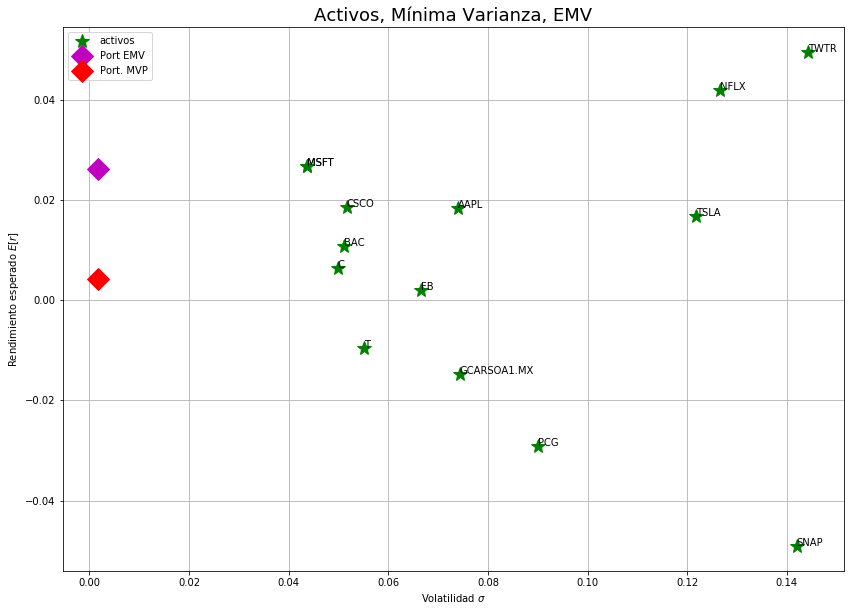

In [821]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,10))

x = monthly_ret_summary.loc['Volatility'].values
y = monthly_ret_summary.loc['Mean'].values

plt.title('Activos, Mínima Varianza, EMV',size=18)

plt.plot(x,y,'*g',ms=15,label='activos')

plt.plot(sp_EMV,Er_EMV,'D',label='Port EMV',ms=15,color='m')
plt.plot(sp_MVP,Er_MVP,'Dr',label='Port. MVP',ms=15)

plt.legend(loc='best')
plt.xlabel('Volatilidad $\sigma$')
plt.ylabel('Rendimiento esperado $E[r]$')

for i in np.arange(len(names)):
    plt.text(x[i],y[i],monthly_ret_summary.columns[i])

plt.grid()
plt.show()

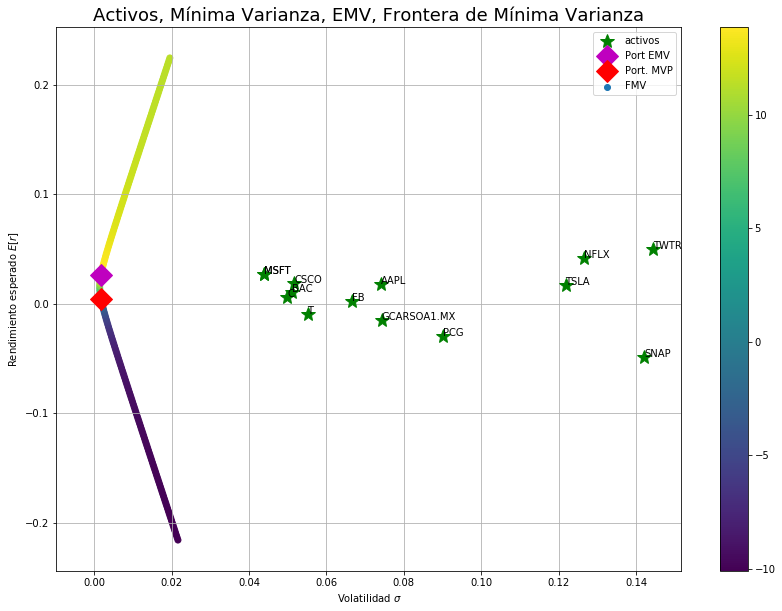

In [828]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,10))

plt.title('Activos, Mínima Varianza, EMV, Frontera de Mínima Varianza',size=18)
plt.scatter(frontera['Sigma $\sigma$'],frontera['E[r]'],c=frontera['Sharpe'],cmap='viridis',label='FMV')
plt.colorbar()

plt.plot(monthly_ret.std().values,monthly_ret.mean(),'*g',ms=15,label='activos')

plt.plot(sp_EMV,Er_EMV,'D',label='Port EMV',ms=15,color='m')
plt.plot(sp_MVP,Er_MVP,'Dr',label='Port. MVP',ms=15)

plt.legend(loc='best')
plt.xlabel('Volatilidad $\sigma$')
plt.ylabel('Rendimiento esperado $E[r]$')

for i in np.arange(len(names)):
    plt.text(x[i],y[i],monthly_ret_summary.columns[i])

plt.grid()
plt.show()

## Conclusiones.

## Referencias.

- Bernarbé, Jorge (2013). * Optimización en Python: * CVXOpt Recuperado de: https://www.pybonacci.org/2013/12/13/optimizacion-en-python-cvxopt/
- Berrendero, J. (s.f.) * Funciones convexas y optimización convexa * Recuperado de: http://verso.mat.uam.es/~joser.berrendero/cursos/Matematicas-IO/io-tema4-16.pdf

### Comparando la librería con la función *minimize*.

Portafolio minvar (minimize)

In [696]:
# Dato inicial
n = len(names)
w0 = np.ones(n)/n
# Cotas de las variables
bnds = ((0,1),)*n
# Restricciones
cons = ({'type': 'eq', 'fun': lambda w: np.sum(w)-1},)

In [701]:
Vol = monthly_ret.std()
D = np.diag(Vol)
Sigma = D.dot(corr).dot(D)

In [702]:
# Portafolio de mínima varianza
minvar = minimize(var,w0,args = (Sigma),bounds =bnds, constraints = cons)
minvar

     fun: 0.0006836047408823158
     jac: array([0.00162896, 0.00119314, 0.00147926, 0.00124306, 0.00166244,
       0.00131225, 0.00160417, 0.00114886, 0.00148301, 0.00138415,
       0.00125719])
 message: 'Optimization terminated successfully.'
    nfev: 286
     nit: 22
    njev: 22
  status: 0
 success: True
       x: array([2.61519400e-19, 2.55282365e-01, 1.18600293e-01, 6.85519634e-03,
       6.19243553e-02, 1.12495459e-01, 0.00000000e+00, 6.67172474e-02,
       3.00534413e-01, 6.46109941e-02, 1.29796776e-02])

In [704]:
# Pesos, rendimiento y riesgo del portafolio de mínima varianza
w_minvar = minvar.x
Er_minvar = Eind.dot(w_minvar)
sp_minvar = np.sqrt(var(w_minvar,Sigma))
sharpe_minvar = sharpe(Er_minvar,sp_minvar,rf)
w_minvar,Er_minvar,sp_minvar,sharpe_minvar

(array([2.61519400e-19, 2.55282365e-01, 1.18600293e-01, 6.85519634e-03,
        6.19243553e-02, 1.12495459e-01, 0.00000000e+00, 6.67172474e-02,
        3.00534413e-01, 6.46109941e-02, 1.29796776e-02]),
 0.008443704061185983,
 0.02614583601421679,
 0.2235041961560713)

In [705]:
# Portafolio EMV2
EMV2 = minimize(max_sharpe,w0,args=(Sigma,rf,Eind),bounds=bnds,constraints=cons)
EMV2

     fun: -0.4553921395554978
     jac: array([ 0.10975162, -0.07089613,  0.10909894, -0.07235615, -0.07067232,
        0.19043102,  0.00576509,  0.06177509, -0.07115005, -0.07071508,
       -0.070904  ])
 message: 'Optimization terminated successfully.'
    nfev: 118
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([2.64941630e-17, 5.77642628e-01, 1.05552633e-17, 2.40222228e-02,
       6.07393410e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.17877690e-02, 2.36338380e-01, 1.94696585e-02])

In [707]:
# Pesos, rendimiento y riesgo del portafolio EMV
w_EMV2 = EMV2.x
Er_EMV2 = Eind.dot(w_EMV2)
sp_EMV2 = np.sqrt(w_EMV.dot(Sigma).dot(w_EMV2))
sharpe_EMV2 = (Er_EMV2-rf)/sp_EMV2
w_EMV2,Er_EMV2,sp_EMV2,sharpe_EMV2

(array([2.64941630e-17, 5.77642628e-01, 1.05552633e-17, 2.40222228e-02,
        6.07393410e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        8.17877690e-02, 2.36338380e-01, 1.94696585e-02]),
 0.019291629718202814,
 0.037437532722494005,
 0.4458528248089864)

In [708]:
# Covarianza entre los portafolios
cov2 = w_minvar.dot(Sigma).dot(w_EMV2)
cov2

0.000646469640481051

In [709]:
# Correlación entre los portafolios
corr2 = cov2/(sp_minvar*sp_EMV2)
corr2

0.6604476238921568

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Francisco Enriquez, Job Ramírez & Oscar Flores.
</footer>